In [1]:
from pathlib import Path
import pandas as pd

DATA_PATH = Path('/Users/powerbai/Desktop/Power Bai/Data Analyst Bootcamp/Portfolio Projects/bike-share-demand-analysis/data_processed/daily_demand.csv')

daily = pd.read_csv(
    DATA_PATH,
    parse_dates = ["date"]
)

daily_ts = (
    daily
    .set_index("date")
    .asfreq("D")
)

daily_ts = daily_ts.loc["2024-07-01":]

daily_ts.head(), daily_ts.shape

(            daily_ride_count  avg_ride_length_min
 date                                             
 2024-07-01             21555            18.747473
 2024-07-02             23031            17.405056
 2024-07-03             25046            18.489790
 2024-07-04             23612            25.173394
 2024-07-05             26092            23.219040,
 (549, 2))

In [2]:
n_obs = len(daily_ts)
train_size = int(n_obs * 0.8)

train = daily_ts.iloc[:train_size]
valid = daily_ts.iloc[train_size:]

train.shape, valid.shape

((439, 2), (110, 2))

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    train["daily_ride_count"],
    order = (1, 1, 1),
    seasonal_order = (1, 1, 1, 7),
    enforce_stationarity = False,
    enforce_invertibility = False
)

sarima_res = model.fit(disp = False)
sarima_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                  daily_ride_count   No. Observations:                  439
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -4044.205
Date:                           Wed, 07 Jan 2026   AIC                           8098.409
Time:                                   20:32:58   BIC                           8118.634
Sample:                               07-01-2024   HQIC                          8106.402
                                    - 09-12-2025                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3429      0.104      3.285      0.001       0.138       0.548
ma.L1         -0.8869      0.058    -15.397      0.000      -1.000      -0.774
ar.S.L7       -0.0625      0.106     -0.589      0.556      -0.271       0.145
ma.S.L7       -0.7573      0.061    -12.512      0.000      -0.876      -0.639
sigma2      1.947e+07   2.06e-09   9.46e+15      0.000    1.95e+07    1.95e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               460.16
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -1.20
Prob(H) (two-sided):                  0.13   Kurtosis:                         7.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.85e+31. Standard errors may be unstable.
"""

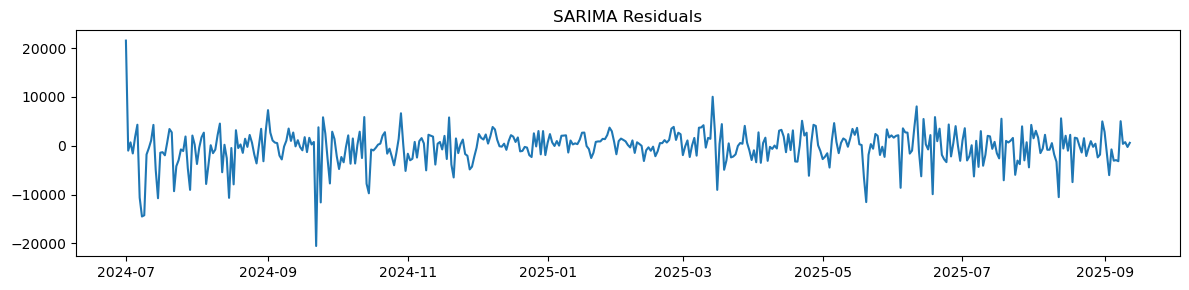

In [4]:
resid = sarima_res.resid

import matplotlib.pyplot as plt

plt.figure(figsize = (12, 3))
plt.plot(resid)
plt.title("SARIMA Residuals")
plt.tight_layout()
plt.show()

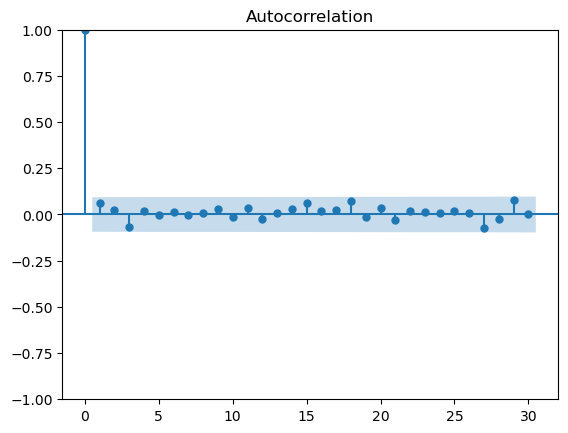

In [5]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(resid.dropna(), lags = 30)
plt.show()

In [6]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(resid.dropna(), lags = [7, 14], return_df = True)

,lb_stat,lb_pvalue
7,4.184543,0.758293
14,5.889863,0.969191


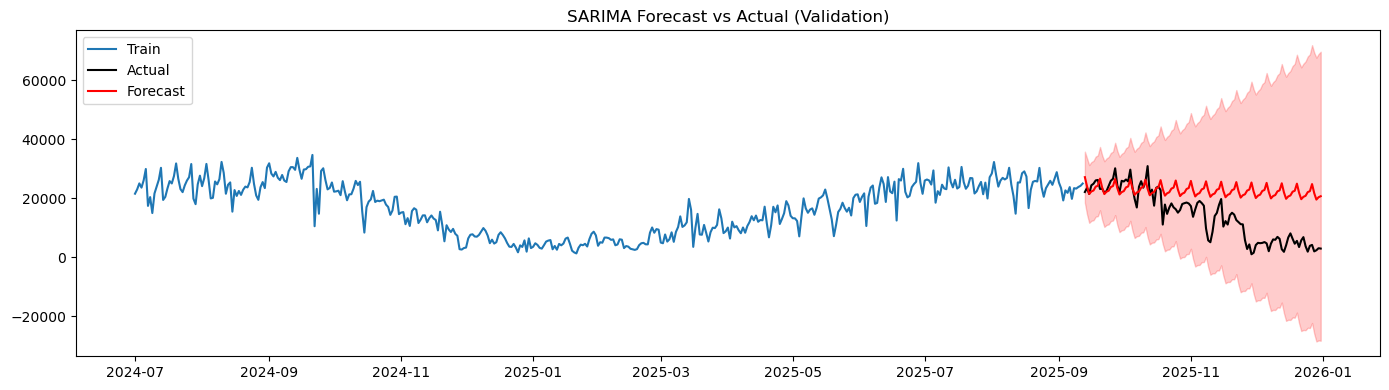

In [7]:
n_valid = len(valid)

forecast_res = sarima_res.get_forecast(steps = n_valid)
pred = forecast_res.predicted_mean
ci = forecast_res.conf_int()

plt.figure(figsize = (14,4))
plt.plot(train.index, train["daily_ride_count"], label = "Train")
plt.plot(valid.index, valid["daily_ride_count"], label = "Actual", color = "black")
plt.plot(valid.index, pred, label = "Forecast", color = "red")

plt.fill_between(valid.index, ci.iloc[:,0], ci.iloc[:,1], color = "red", alpha = 0.2)
plt.legend()
plt.title("SARIMA Forecast vs Actual (Validation)")
plt.tight_layout()
plt.show()